In [3]:
# importing helper libraries
import numpy as np
import pandas as pd
# import machine learning libraries
import tensorflow as tf
from tensorflow import keras
# Importing data preprocessing techniques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

# Data Reading, Downloaded from Yahoo Finance

In [4]:
data = pd.read_csv("../BTC-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-23,5399.365723,5633.802246,5389.408691,5572.362305,5572.362305,1.586731e+10
1,2019-04-24,5571.508301,5642.044434,5418.263184,5464.866699,5464.866699,1.704803e+10
2,2019-04-25,5466.524414,5542.238281,5181.338867,5210.515625,5210.515625,1.533028e+10
3,2019-04-26,5210.304688,5383.634277,5177.368652,5279.348145,5279.348145,1.681211e+10
4,2019-04-27,5279.471191,5310.750000,5233.635742,5268.291016,5268.291016,1.311127e+10


In [5]:
data.isna().astype("int").sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [6]:
# we need to remove null or NaN value from our dataset
data.dropna(inplace = True)
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
required_data = data[["High", "Low", "Close"]]
required_data.head()

,High,Low,Close
0,5633.802246,5389.408691,5572.362305
1,5642.044434,5418.263184,5464.866699
2,5542.238281,5181.338867,5210.515625
3,5383.634277,5177.368652,5279.348145
4,5310.750000,5233.635742,5268.291016


# Data Preprocessing

In [241]:
train_data_length = int(0.99 * len(required_data))

In [242]:
# Before we normalize the data, we need to split the data into train and test split, so that data snooping can be
# avoided

train_data = required_data.iloc[:train_data_length]
test_data = required_data.iloc[train_data_length:]

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (1809, 3)
Testing data : (19, 3)


In [243]:
# Data Normalization
# This will scale the data between -1 and 1
normalizer = MinMaxScaler(feature_range = (-1, 1))
# Fit the normalizer on the train data only
normalizer.fit(train_data)


# converting the train data
train_data = normalizer.transform(train_data)
test_data  = normalizer.transform(test_data)

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (1809, 3)
Testing data : (19, 3)


In [244]:
import pickle

with open("../models/preprocessor.prec", "wb") as f:
    pickle.dump(normalizer, f)

In [245]:
# checking the range of train data and test data
print(f"Maximum and minimum value of training data : {np.max(train_data), np.min(train_data)}")
print(f"Maximum and minimum value of testing  data : {np.max(test_data), np.min(test_data)}")

Maximum and minimum value of training data : (1.0, -1.0)
Maximum and minimum value of testing  data : (0.9697626763893079, 0.6524407299485733)


In [246]:
# this piece of code creates the data where features and targets are multivariate

def create_window_split_with_target_multivariate(data, window_size, horizon=1, stride=1):
    """
    Function to split a multivariate time series data into overlapping windows and generate target variables.
    
    Parameters:
        data (numpy.ndarray): The input multivariate time series data with shape (num_samples, num_features).
        window_size (int): Size of each window.
        horizon (int): Forecast horizon, i.e., number of future time steps to predict. Default is 1.
        stride (int): The stride or step size between consecutive windows. Default is 1.
    
    Returns:
        numpy.ndarray, numpy.ndarray: Arrays containing the split windows and corresponding target variables.
    """
    num_samples = len(data)
    num_features = data.shape[1]
    num_windows = (num_samples - window_size - horizon) // stride + 1
    windows = np.zeros((num_windows, window_size, num_features))
    targets = np.zeros((num_windows, num_features))
    
    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        windows[i] = data[start_index:end_index]
        targets[i] = data[end_index + horizon - 1]  # Assuming the target is the value at the end of the forecast horizon
    
    return windows, targets


window_size = 15
horizon = 1
stride = 1

train_features, train_lables = create_window_split_with_target_multivariate(train_data, window_size, horizon, stride)
test_features, test_lables = create_window_split_with_target_multivariate(test_data, window_size, horizon, stride)


print(f"Training Data : {train_features.shape, train_lables.shape}")
print(f"Testing Data : {test_features.shape, test_lables.shape}")

Training Data : ((1794, 15, 3), (1794, 3))
Testing Data : ((4, 15, 3), (4, 3))


# Model Training and Evaluation

In [288]:
from tensorflow.keras.layers import GRU

model = tf.keras.Sequential(
    [
        keras.layers.Input(shape = (15, 3)),
        keras.layers.Bidirectional(GRU(units = 64, activation = "gelu", return_sequences = True)),
        keras.layers.LayerNormalization(),
        keras.layers.Bidirectional(GRU(units = 128, activation = "gelu")),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(units = 64, activation = "gelu"),
        keras.layers.Dense(units = 3, activation = "elu")  
    ]
)
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_36 (Bidirect  (None, 15, 128)           26496     
 ional)                                                          
                                                                 
 layer_normalization_4 (Lay  (None, 15, 128)           256       
 erNormalization)                                                
                                                                 
 bidirectional_37 (Bidirect  (None, 256)               198144    
 ional)                                                          
                                                                 
 layer_normalization_5 (Lay  (None, 256)               512       
 erNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 64)              

In [289]:
callbacks = []

# model_ckpts = tf.keras.callbacks.ModelCheckpoint("../models/bigru/", monitor = "val_loss", save_best_only = True)
early_stops = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

# callbacks.append(model_ckpts)
callbacks.append(early_stops)

In [290]:
model.compile(optimizer = keras.optimizers.AdamW(learning_rate = 0.001), loss = "mse", metrics = ["mse", "mae"])

In [291]:
history = model.fit(train_features, train_lables, epochs = 100, validation_data = (test_features, test_lables), callbacks = callbacks)

Epoch 1/100
57/57 [==============================] - 8s 35ms/step - loss: 0.1180 - mse: 0.1180 - mae: 0.2224 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0976
Epoch 2/100
57/57 [==============================] - 1s 22ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0765 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1485
Epoch 3/100
57/57 [==============================] - 1s 21ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0589 - val_loss: 0.0107 - val_mse: 0.0107 - val_mae: 0.0993
Epoch 4/100
57/57 [==============================] - 1s 21ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0454 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0421
Epoch 5/100
57/57 [==============================] - 1s 21ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0382 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0644
Epoch 6/100
57/57 [==============================] - 1s 21ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0353 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0409
Epoch 7/100
57/5

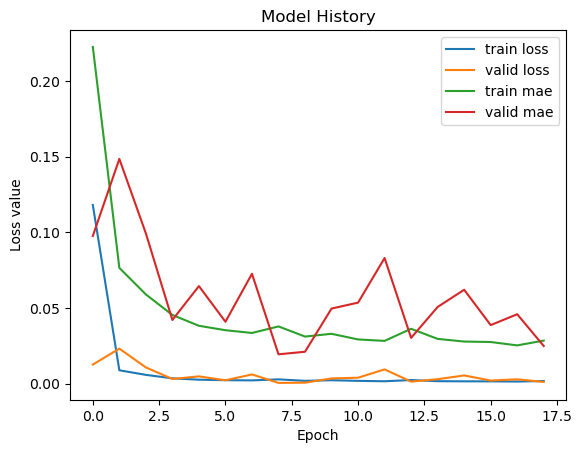

In [292]:

train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

train_mae = history.history["mae"]
valid_mae = history.history["val_mae"]

plt.title("Model History")

plt.plot(range(len(train_loss)), train_loss, label = "train loss")
plt.plot(range(len(valid_loss)), valid_loss, label = "valid loss")

plt.plot(range(len(train_mae)), train_mae, label = "train mae")
plt.plot(range(len(valid_mae)), valid_mae, label = "valid mae")
plt.xlabel("Epoch")
plt.ylabel("Loss value")

plt.legend()
plt.show()

In [293]:
model.evaluate(x = test_features, y = test_lables)

1/1 [==============================] - 0s 39ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0249


[0.001110531622543931, 0.001110531622543931, 0.02485594153404236]

In [294]:
model.save("../models/bigru.keras")

In [295]:
model = tf.keras.models.load_model("../models/bigru.keras")

In [296]:
test_predicts = model.predict(test_features)

1/1 [==============================] - 1s 1s/step


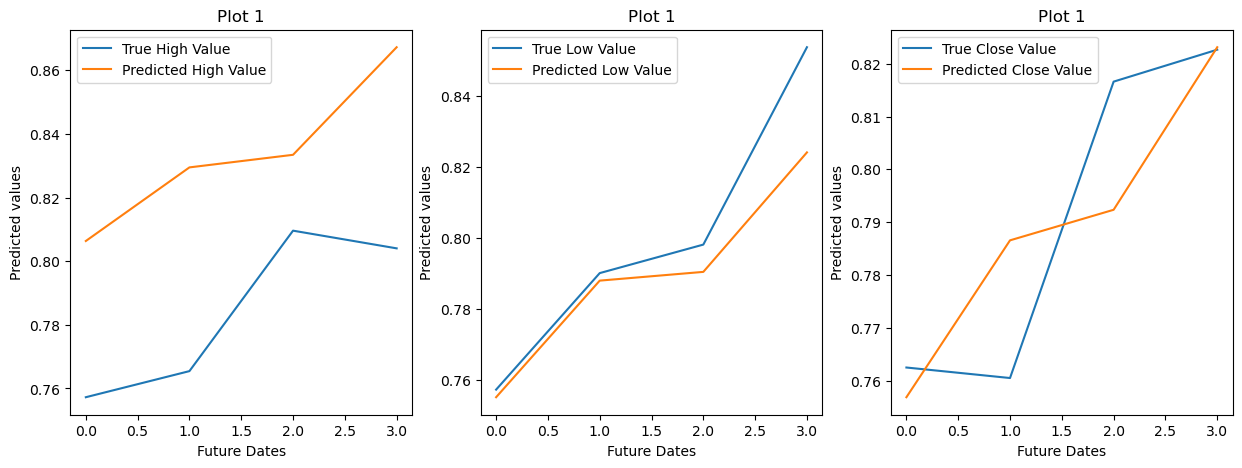

In [297]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(test_lables[:, 0], label = "True High Value")
axes[0].plot(test_predicts[:, 0], label = "Predicted High Value")
axes[0].set_title('Plot 1')
axes[0].set_xlabel('Future Dates')
axes[0].set_ylabel('Predicted values')
axes[0].legend()

axes[1].plot(test_lables[:, 1], label = "True Low Value")
axes[1].plot(test_predicts[:, 1], label = "Predicted Low Value")
axes[1].set_title('Plot 1')
axes[1].set_xlabel('Future Dates')
axes[1].set_ylabel('Predicted values')
axes[1].legend()

axes[2].plot(test_lables[:, 2], label = "True Close Value")
axes[2].plot(test_predicts[:, 2], label = "Predicted Close Value")
axes[2].set_title('Plot 1')
axes[2].set_xlabel('Future Dates')
axes[2].set_ylabel('Predicted values')
axes[2].legend()
plt.show()

In [300]:
import numpy as np

def predict_future_values(model, initial_data, num_predictions):
    predictions = []
    
    # Reshape initial data if necessary
    initial_data = np.array(initial_data)
    if len(initial_data.shape) == 2:
        initial_data = np.expand_dims(initial_data, axis=0)

    for _ in range(num_predictions):
        # Predict next value based on initial data
        prediction = model.predict(initial_data)
        
        # Append the predicted value to initial data for next prediction
        initial_data = np.concatenate((initial_data[:, 1:], np.expand_dims(prediction, axis=1)), axis=1)
        
        # Append the prediction to the list of predictions
        predictions.append(np.squeeze(prediction).tolist())
    
    predictions = np.asarray(predictions)
    
    return predictions

# Example usage:
# Assuming 'model' and 'test_features' are already defined
initial_data = test_features[0].reshape(1, 15, 3)
num_predictions = len(test_features)  # Number of predictions to make
predictions = predict_future_values(model, initial_data, num_predictions = 70)

1/1 [==============================] - 0s 24ms/step


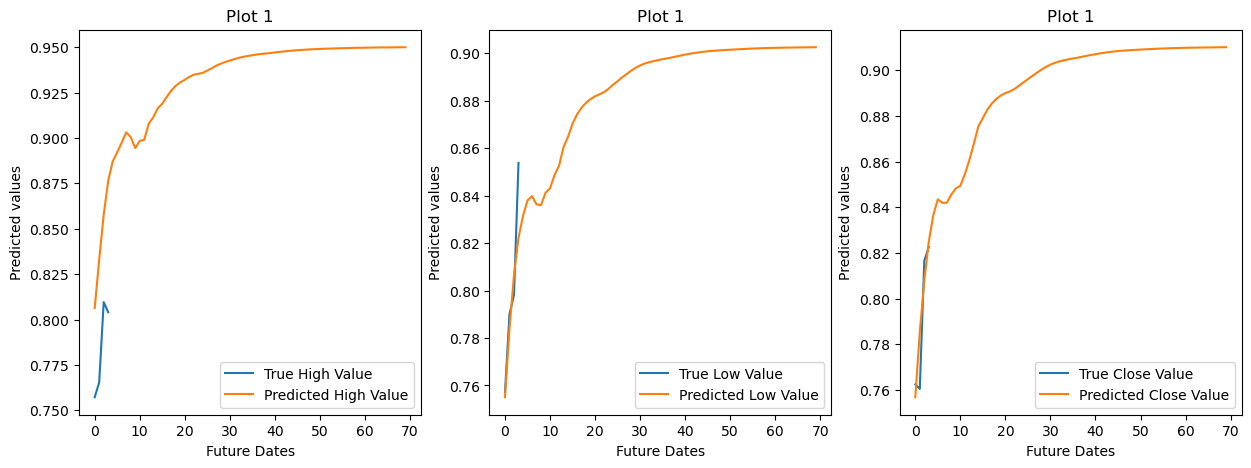

In [301]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(test_lables[:, 0], label = "True High Value")
axes[0].plot(predictions[:, 0], label = "Predicted High Value")
axes[0].set_title('Plot 1')
axes[0].set_xlabel('Future Dates')
axes[0].set_ylabel('Predicted values')
axes[0].legend()

axes[1].plot(test_lables[:, 1], label = "True Low Value")
axes[1].plot(predictions[:, 1], label = "Predicted Low Value")
axes[1].set_title('Plot 1')
axes[1].set_xlabel('Future Dates')
axes[1].set_ylabel('Predicted values')
axes[1].legend()

axes[2].plot(test_lables[:, 2], label = "True Close Value")
axes[2].plot(predictions[:, 2], label = "Predicted Close Value")
axes[2].set_title('Plot 1')
axes[2].set_xlabel('Future Dates')
axes[2].set_ylabel('Predicted values')
axes[2].legend()
plt.show()